# Distribución granulométrica de suelos

© 2023 Daniel F. Ruiz, Exneyder A. Montoya-Araque y Universidad EAFIT.

You can execute this notebook interactively →  [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AppliedMechanics-EAFIT/soil_mechanics/blob/main/notebooks/particle_size_distrib.ipynb)  or  [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/AppliedMechanics-EAFIT/soil_mechanics/main?filepath=notebooks/particle_size_distrib.ipynb)

Las rutinas de clasificación se basan parcialmente en la norma [ASTM ASTM D6913/D6913M-17](https://www.astm.org/d6913-04r09e01.html)

## Required modules and global setup for plots

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import norm, lognorm
from scipy.optimize import curve_fit, minimize
from ipywidgets import widgets as wgt
from IPython import get_ipython

if 'google.colab' in str(get_ipython()):
    print('Running on CoLab. Installing the required modules...')
    from subprocess import run
    run('pip install ipympl', shell=True);
    from google.colab import output, files
    output.enable_custom_widget_manager()
else:
    import tkinter as tk
    from tkinter.filedialog import askopenfilename

# %matplotlib widget
mpl.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman", "cmr", "cmr10", "DejaVu Serif"],  # or 
    "mathtext.fontset": "cm",  # Use Computer Modern fonts for math
    "axes.formatter.use_mathtext": True,  # Use mathtext for axis labels
    "axes.unicode_minus": False,   # Use standard minus sign instead of a unicode character
})

# Reading the input data

In [2]:
if 'google.colab' in str(get_ipython()):
    file = files.upload()
    df = pd.read_excel(list(file.values())[0])
else:
    tk.Tk().withdraw() # part of the import if you are not using other tkinter functions
    file = askopenfilename()
    df = pd.read_excel(file)

# Tabulated input data

In [3]:
df

,Tamiz,Abertura_(mm),Retenido_(g)
0,"2 1/2""",63.500,NaN
1,"2""",50.800,NaN
2,"1 1/2""",38.100,NaN
3,"1""",25.400,NaN
4,"3/4""",19.100,NaN
5,"1/2""",12.700,0.0
6,NaN,4.000,3.0
7,NaN,2.000,6.0
8,NaN,1.000,15.0
9,NaN,0.500,22.5


## Funciones

In [4]:
def complete_table(df, total_sample_weight=0, washed_weight=0):
    df_full = df.fillna(0, inplace=False)
    washed_fines = total_sample_weight - washed_weight
    # df_full.iat[-1, df_full.columns.get_loc('Retenido_(g)')] = 3
    df_full.loc[len(df_full)-1, 'Retenido_(g)'] = df_full['Retenido_(g)'].iloc[-1] + washed_fines
    # df_full['Retenido_(g)'].iloc[-1] = df_full['Retenido_(g)'].copy().iloc[-1] + washed_fines
    total_weight = df_full['Retenido_(g)'].sum()
    df_full['Retenido_(%)'] = 100 * df_full['Retenido_(g)'] / total_weight
    df_full['Retenido_acum_(%)'] = 100 * np.cumsum(df_full['Retenido_(g)']) / total_weight
    df_full['No_retenido_(%)'] = 100 - df_full['Retenido_acum_(%)']
    return df_full

In [5]:
def plot_granulometric_curve(df, figsize=None):
    figsize = [6.5, 5.5] if figsize is None else figsize
    sieve = ['4', '10', '20', '40', '100', '200']
    diameters = [4.75, 2, 0.84, 0.42, 0.149, 0.074]
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=figsize, layout='constrained')
    ax.semilogx(
        df['Abertura_(mm)'].iloc[:-1], df['No_retenido_(%)'].iloc[:-1], ls="-", lw=1.5, color="C0")
    # Format
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.grid(True, which='both', ls="--", lw=0.5)
    # ax.set_aspect("equal", anchor=None)
    ax.set(xlabel='Diameter [mm]', ylabel='Percent passing [%]')
    ax.set_xlim(100, 1e-2)
    ax.set_ylim(0, 100)
    [ax.spines[i].set_linewidth(1.5) for i in ["bottom", "left", "top", "left"]]
    ax.tick_params(width=1.5)
    # Upper axis labels
    ax_twiny = ax.twiny()
    ax_twiny.semilogx(
        df['Abertura_(mm)'].iloc[:-1], df['No_retenido_(%)'].iloc[:-1], ls="", marker=".", color="C0")
    ax_twiny.set_xlim(ax.get_xlim())
    ax_twiny.set_xlabel("Sieve N$^\circ$")
    ax_twiny.minorticks_off()
    ax_twiny.set_xticks(diameters)
    ax_twiny.set_xticklabels(sieve)
    ax_twiny.tick_params(width=1.5)
    plt.show()
    return

In [6]:
# Define the lognormal CDF function for curve fitting
def lognorm_cdf_func(x, shape, scale):
    return lognorm.cdf(x, shape, 0, scale)

def fit_lognorm(x, y, method='nlls', p0=None):
    p0 = [1, 0.5, 0.5] if p0 is None else p0
    if method == 'nlls':
        mask = ~np.isnan(y)
        x, y = x[mask], y[mask]
        bounds=([1e-9, -np.inf, 1e-9], [np.inf, np.inf, np.inf])
        params, pcov = curve_fit(lognorm.cdf, x, y, p0=p0, bounds=bounds)
    return params

def plot_granulometric_curve_fit(df, figsize=None):
    figsize = [7, 3.5] if figsize is None else figsize
    sieve = ['4', '10', '20', '40', '100', '200']
    diameters = [4.75, 2, 0.84, 0.42, 0.149, 0.074]
    x = np.flip(np.array(df['Abertura_(mm)']))
    xx = np.geomspace(x[1], x[-1], 1000)
    y_finer = np.flip(np.array(df['No_retenido_(%)']))
    y_ret = np.flip(np.array(df['Retenido_(%)']))
    widths = np.concatenate((np.diff(x), [2 * np.diff(x)[-1]]))

    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=figsize)
    ax.bar(x, y_ret, width=widths, fill=False, edgecolor='k', align='edge',
        label='Probability mass function', zorder=1)
    ax.plot(x, y_ret, ls='', marker='x', c='C0', ms=7, label='Retained weight')
    ax.plot(x, y_finer, ls='--', marker='o', c='C0', mfc='w', ms=7,
        label='Weight finer than the retained')

    # params_nlls = fit_lognorm(x[1:], y_finer[1:]/100, 'nlls')
    (shape, scale), pcov = curve_fit(
        lognorm_cdf_func, x[1:], y_finer[1:]/100, p0=[1, np.median(x[1:])])
    mean, var = lognorm.stats(shape, 0, scale, moments='mv')
    ax.plot(xx, 100*lognorm.cdf(xx, shape, 0, scale), ls='-', c='C1', lw=2.5, alpha=0.8,
            label=f"$\\sigma={shape:.2f}$, $e^\\mu={scale:.2f}$\n$E[X]={mean:.2f}$, $\mathrm{{Var}}[X]={var:.2f}$")

    # Format
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.grid(True, which='both', ls="--", lw=0.5)
    ax.set(xlabel='Diameter [mm]', ylabel='Percent passing or retained [%]')
    ax.tick_params(width=1.5)
    # ax.set_xlim(1e-2, 100)
    # ax.set_ylim(-3, 103)
    [ax.spines[i].set_linewidth(1.5) for i in ["bottom", "left", "top"]]
    # Upper axis labels
    ax_twiny = ax.twiny()
    ax_twiny.plot(x, y_finer, ls='', marker='x', ms=0, c='r')
    ax.set_xscale('log')
    ax_twiny.set_xscale('log')
    ax_twiny.set_xlim(ax.get_xlim())
    ax_twiny.set_xlabel("Sieve N$^\circ$")
    ax_twiny.minorticks_off()
    ax_twiny.set_xticks(diameters)
    ax_twiny.set_xticklabels(sieve)
    ax_twiny.tick_params(width=1.5)
    plt.show()
    return

def plot_pdf_cdf_granulometric_curve(df, figsize=None):
    figsize = [6.5, 6.5] if figsize is None else figsize
    sieve = ['4', '10', '20', '40', '100', '200']
    diameters = [4.75, 2, 0.84, 0.42, 0.149, 0.074]
    x = np.flip(np.array(df['Abertura_(mm)']))
    y_finer = np.flip(np.array(df['No_retenido_(%)']))
    y_ret = np.flip(np.array(df['Retenido_(%)']))
    widths = np.concatenate((np.diff(x), [2 * np.diff(x)[-1]]))
    colors = plt.get_cmap('Set3')(range(len(widths)))

    fig, axs = plt.subplots(ncols=1, nrows=2, sharex=True, sharey=True,
                            figsize=figsize, layout='compressed')

    axs[0].bar(x, y_ret, width=widths, bottom=y_finer, color=colors,
        edgecolor='k', align='edge', alpha=.8)
    axs[0].plot(x, y_finer, ls='--', lw=1.5, marker='o', c='k', mfc='w', ms=5)

    axs[1].bar(x, y_ret, width=widths, color=colors, edgecolor='k',
               align='edge', alpha=.8)
    axs[1].plot(x, y_ret, ls='', marker='o', c='k', mfc='w', ms=5)

    # Format
    axs[0].set_xscale('log')
    axs[0].set_ylim((-3, 103))
    axs[0].set(ylabel='Percent passing [%]')
    axs[1].set(xlabel='Diameter [mm]', ylabel='Percent retained [%]')
    for ax in axs:
        # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.grid(True, which='both', ls="--", lw=0.5)
        ax.spines[["bottom", "left"]].set_linewidth(1.5)
        ax.tick_params(width=1.5)
    # Upper axis labels
    ax_twiny = axs[0].twiny()
    ax_twiny.plot(x, y_finer, ls='', marker='.', ms=0, c='b')
    ax_twiny.set_xscale('log')
    ax_twiny.set_xlim(axs[0].get_xlim())
    ax_twiny.set_xlabel("Sieve N$^\circ$")
    ax_twiny.minorticks_off()
    ax_twiny.set_xticks(diameters)
    ax_twiny.set_xticklabels(sieve)
    ax_twiny.spines[["top", "left"]].set_linewidth(1.5)
    ax_twiny.tick_params(width=1.5)
    plt.show()
    return

In [7]:
def get_Cc_Cu(df, hztl, D60=1, D30=1, D10=1):
    figsize = [6., 3.5]# if figsize is None else figsize
    sieve = ['4', '10', '20', '40', '100', '200']
    diameters = [4.75, 2, 0.84, 0.42, 0.149, 0.074]
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=figsize)
    if D60==1 and  D30==1 and D10==1:
        label = f'Cc: -\nCu: -'
    else:
        Cu = D60/D10
        Cc = D30**2/(D60*D10)
        label = f'Cc: {Cc:.1f}\nCu: {Cu:.1f}'
    ax.semilogx(df['Abertura_(mm)'].iloc[:-1], df['No_retenido_(%)'].iloc[:-1],
                ls="-", lw=1.5, color="C0", label=label)
    # Format
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.grid(True, which='both', ls="--", lw=0.5)
    ax.set(xlabel='Diameter [mm]', ylabel='Percent passing [%]')
    ax.set_xlim(100, 1e-2)
    ax.set_ylim(0, 100)
    [ax.spines[i].set_linewidth(1.5) for i in ["bottom", "left", "top", "left"]]
    ax.tick_params(width=1.5)
    ax.axhline(hztl, ls='--', c='k', lw='1.5')
    ax.axvline(D60, ls='--', c='C1', lw='1.5')
    ax.axvline(D30, ls='--', c='C2', lw='1.5')
    ax.axvline(D10, ls='--', c='C3', lw='1.5')
    # Upper axis labels
    ax_twiny = ax.twiny()
    ax_twiny.semilogx(
        df['Abertura_(mm)'].iloc[:-1], df['No_retenido_(%)'].iloc[:-1], ls="", marker=".", color="C0")
    ax_twiny.set_xlim(ax.get_xlim())
    ax_twiny.set_xlabel("Sieve N$^\circ$")
    ax_twiny.minorticks_off()
    ax_twiny.set_xticks(diameters)
    ax_twiny.set_xticklabels(sieve)
    ax_twiny.spines[["bottom", "left"]].set_linewidth(1.5)
    ax_twiny.tick_params(width=1.5)
    plt.show()
    return

# Completing the table

If there is a washing stage on the sieve No. 200, include the weight of the total sample before washing (`total_sample_weight`) and the weight of the sample after being washed (`washed_weight`) as input variables in the `complete_table` function.  If these two optional parameters are not input, the total weight of the sample will be computed as the sum of the retained weights.

See the commented line in the following code cell as an example.

In [8]:
df_full = complete_table(df)
# df_full = complete_table(df, total_sample_weight=442.7, washed_weight=265.56)
df_full

,Tamiz,Abertura_(mm),Retenido_(g),Retenido_(%),Retenido_acum_(%),No_retenido_(%)
0,"2 1/2""",63.500,0.0,0.0,0.0,100.0
1,"2""",50.800,0.0,0.0,0.0,100.0
2,"1 1/2""",38.100,0.0,0.0,0.0,100.0
3,"1""",25.400,0.0,0.0,0.0,100.0
4,"3/4""",19.100,0.0,0.0,0.0,100.0
5,"1/2""",12.700,0.0,0.0,0.0,100.0
6,0,4.000,3.0,2.0,2.0,98.0
7,0,2.000,6.0,4.0,6.0,94.0
8,0,1.000,15.0,10.0,16.0,84.0
9,0,0.500,22.5,15.0,31.0,69.0


# Visualizing the granulometric curve

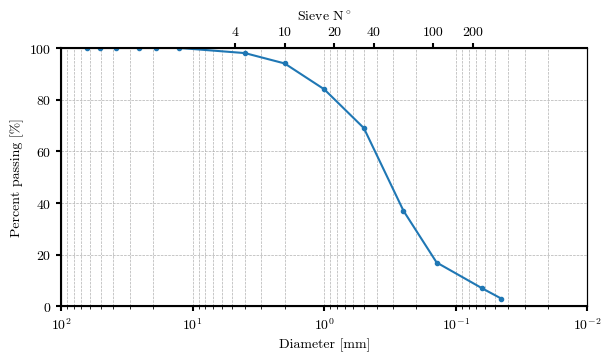

In [9]:
plot_granulometric_curve(df_full, figsize=[6., 3.5])

In [10]:
s, l = {'description_width': '70px'}, wgt.Layout(width='400px')
controls = {
    'df': wgt.fixed(df_full),
    'hztl': wgt.FloatSlider(value=50, step=1, min=0, max=100, description="Auxiliar line", style=s, layout=l),
    'D60': wgt.FloatLogSlider(value=1, step=0.1, min=-2, max=2, base=10, description="D60", style=s, layout=l),
    'D30': wgt.FloatLogSlider(value=1, step=0.1, min=-2, max=2, base=10, description="D30", style=s, layout=l),
    'D10': wgt.FloatLogSlider(value=1, step=0.1, min=-2, max=2, base=10, description="D10", style=s, layout=l),
}
fig = wgt.interactive_output(get_Cc_Cu, controls)
wgt.HBox((wgt.VBox(list(controls.values())[1:]), fig), layout=wgt.Layout(align_items='center'))

## Probabilistic fit to granulometric data

### Discrete input data

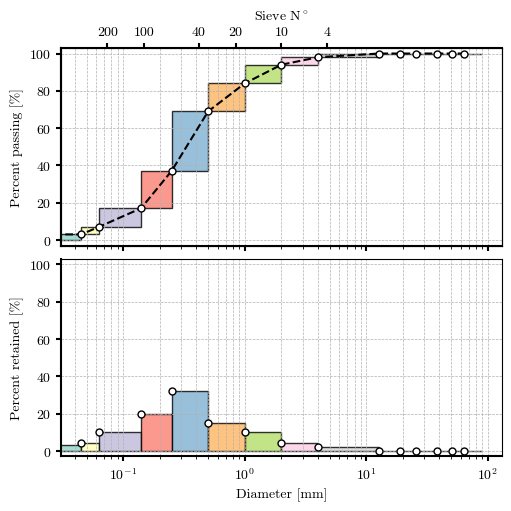

In [11]:
plot_pdf_cdf_granulometric_curve(df_full, figsize=[5, 5])

### Ajuste de una distribución lognormal a una curva granulométrica 

Si una variable aleatoria $Y=\log X$ se distribuye normalmente con media $\mu$ y desviación estándar $\sigma$, entonces la variable aleatoria $X$ es lognormalmente ditribuida con parámetros de forma (`s`=$\sigma$) y escala (`scale`=$e^\mu$)

La función de densidad de probabilidad de distribución lognormal estandarizada sólo es función del parámetro de forma `s`:

$f(x, s) = \frac{1}{s x \sqrt{2\pi}} \exp\left(-\frac{\log^2(x)}{2s^2}\right)$

con $x > 0$, $s > 0$.

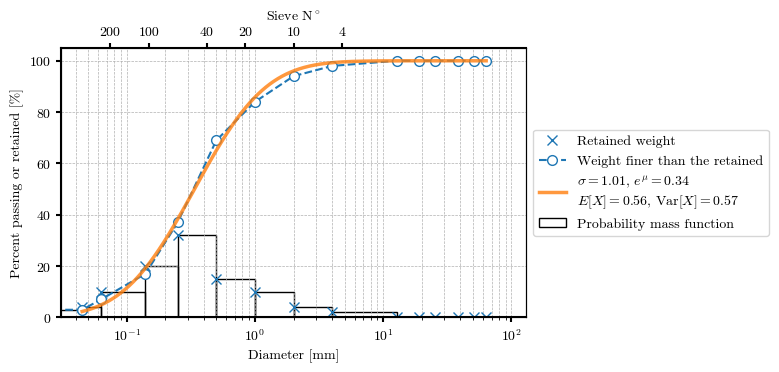

In [12]:
plot_granulometric_curve_fit(df_full, figsize=[6, 3.5])